Darren Liu
##SYSEN 6888
December 01, 2023
##Homework 5: GAN Generate MINST Handwritten Digits

In [ ]:
#loading package dependencies
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
import PIL
import time
from IPython import display
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-q6r1vakw
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-q6r1vakw
  Resolved https://github.com/tensorflow/docs to commit af33301a434ea70e104865b9d2e93e230494c1cb
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=8bf525c28fef96e2e9118dc44265675eefd30503d943eaa6053ff32d6d6780a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-a5k161se/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
#loading MINST Data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
buffer_size = 65000
batch_size = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
latent_dim = 100

In [ ]:
#bulding generator model
def build_generator(latent_dim=100):
    model = Sequential(name="generator")
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(1, kernel_size=(7, 7), strides=(2, 2), activation='tanh', padding='same'))

    return model

In [ ]:
#discriminator model
def build_discriminator(input_shape=(28, 28, 1)):

    model = Sequential(name="discriminator")
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
generator = build_generator(latent_dim)
discriminator = build_discriminator()

In [ ]:
##printing model parameters to double check
print(discriminator.summary())
print(generator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense_1 (Dense)             (None, 1)               

In [ ]:
#setting hyperparameters
epochs = 120
noise_dim = 100
num_examples_to_generate = 16
batch_size = 64
seed = tf.random.normal([num_examples_to_generate, noise_dim])
save_interval = 1

In [ ]:
from google.colab import files
import os
import shutil

# Define a directory to save images
save_dir = '/content/generated_images'

# Ensure the save directory exists
os.makedirs(save_dir, exist_ok=True)

def save_imgs(generator, epoch, save_dir=save_dir, r=5, c=5):
    # Generate noise
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    # Generate images from the noise
    gen_imgs = generator.predict(noise)
    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Create a new figure
    fig, axs = plt.subplots(r, c, figsize=(10, 10))

    cnt = 0
    for i in range(r):
        for j in range(c):
            # Plot the generated images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    # Save the full figure
    fig.savefig(os.path.join(save_dir, f"mnist_epoch_{epoch}.png"))
    # Close the figure
    plt.close()


In [ ]:
#optimizers for generator and discriminator:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)


In [ ]:
# Loss functions for generator and discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)


In [ ]:
@tf.function
def train_step(image_batch, latent_dim, generator, discriminator, generator_optimizer, discriminator_optimizer):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # Use `image_batch` instead of `images`
        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
# Training loop with increased patience
def train(generator, discriminator, train_dataset, epochs, latent_dim, batch_size, generator_optimizer, discriminator_optimizer, save_interval, seed, patience=10):  # Increased patience
    # Lists to keep track of loss
    d_losses = []
    g_losses = []
    min_loss = float('inf')
    wait = 0  # Counter for patience

    for epoch in range(epochs):
        start = time.time()

        # Lists to keep track of loss for each batch
        d_losses_per_epoch = []
        g_losses_per_epoch = []

        for image_batch in train_dataset:
            gen_loss, disc_loss = train_step(image_batch, latent_dim, generator, discriminator, generator_optimizer, discriminator_optimizer)

            # Append the losses for each batch
            g_losses_per_epoch.append(gen_loss.numpy())
            d_losses_per_epoch.append(disc_loss.numpy())

        # Calculate the average loss of the epoch
        epoch_d_loss = np.mean(d_losses_per_epoch)
        epoch_g_loss = np.mean(g_losses_per_epoch)

        # Append the average losses of the epoch to the main list
        d_losses.append(epoch_d_loss)
        g_losses.append(epoch_g_loss)

        # Print the summary statistics for the epoch
        elapsed_time = time.time() - start
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Time for epoch: {elapsed_time:.2f} sec")
        print(f"Discriminator Loss: {epoch_d_loss:.4f}")
        print(f"Generator Loss: {epoch_g_loss:.4f}\n")

        # Check if the generator loss improved
        if epoch_g_loss < min_loss:
            min_loss = epoch_g_loss
            wait = 0  # Reset the counter if there is improvement
        else:
            wait += 1  # Increment the counter if no improvement

        # Early stopping condition
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break  # Stop training

        # Save generated images
        if epoch % save_interval == 0:
            save_imgs(generator, epoch, save_dir=save_dir)

    return d_losses, g_losses


In [ ]:
# Call the training function and capture the loss history
d_loss_history, g_loss_history = train(
    generator=generator,
    discriminator=discriminator,
    train_dataset=train_dataset,
    epochs=epochs,
    latent_dim=latent_dim,
    batch_size=batch_size,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    save_interval=save_interval,
    seed=seed,
    patience=100
)

Epoch 1/120
Time for epoch: 14.74 sec
Discriminator Loss: 1.3306
Generator Loss: 0.6393

1/1 [==============================] - 0s 165ms/step
Epoch 2/120
Time for epoch: 1.20 sec
Discriminator Loss: 1.1363
Generator Loss: 0.7529

1/1 [==============================] - 0s 19ms/step
Epoch 3/120
Time for epoch: 1.22 sec
Discriminator Loss: 1.0363
Generator Loss: 0.7624

1/1 [==============================] - 0s 18ms/step
Epoch 4/120
Time for epoch: 1.22 sec
Discriminator Loss: 0.8721
Generator Loss: 0.9472

1/1 [==============================] - 0s 18ms/step
Epoch 5/120
Time for epoch: 1.21 sec
Discriminator Loss: 1.0680
Generator Loss: 0.6947

1/1 [==============================] - 0s 19ms/step
Epoch 6/120
Time for epoch: 1.21 sec
Discriminator Loss: 1.0401
Generator Loss: 0.7489

1/1 [==============================] - 0s 19ms/step
Epoch 7/120
Time for epoch: 1.18 sec
Discriminator Loss: 1.1728
Generator Loss: 0.7143

1/1 [==============================] - 0s 18ms/step
Epoch 8/120
Time f

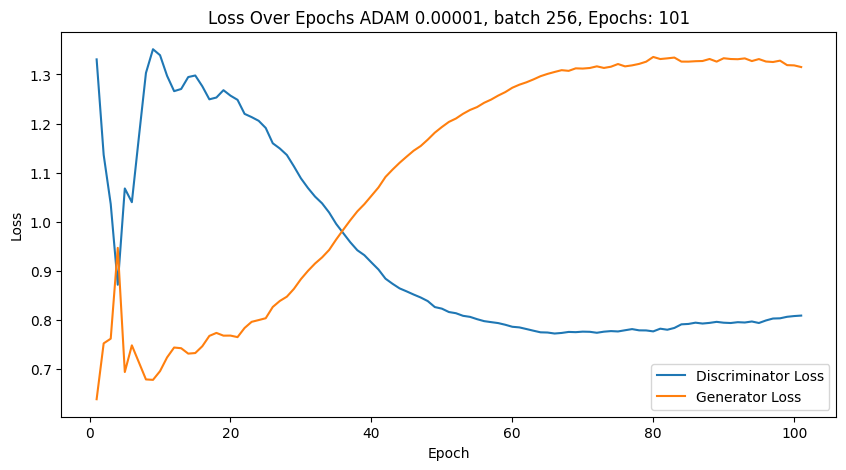

In [ ]:
# Plot the loss against epochs
plt.figure(figsize=(10,5))

# Add a check for the length of the loss histories
epochs_plotted = range(1, len(d_loss_history) + 1)

plt.plot(epochs_plotted, d_loss_history, label='Discriminator Loss')
plt.plot(epochs_plotted, g_loss_history, label='Generator Loss')

# Updating the title with dynamic epoch count based on the actual length of loss history
plt.title(f'Loss Over Epochs ADAM 0.00001, batch 256, Epochs: {len(d_loss_history)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


<ipython-input-17-f489f8ed5421>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


GIF saved in: /content/generated_images/generated_images.gif


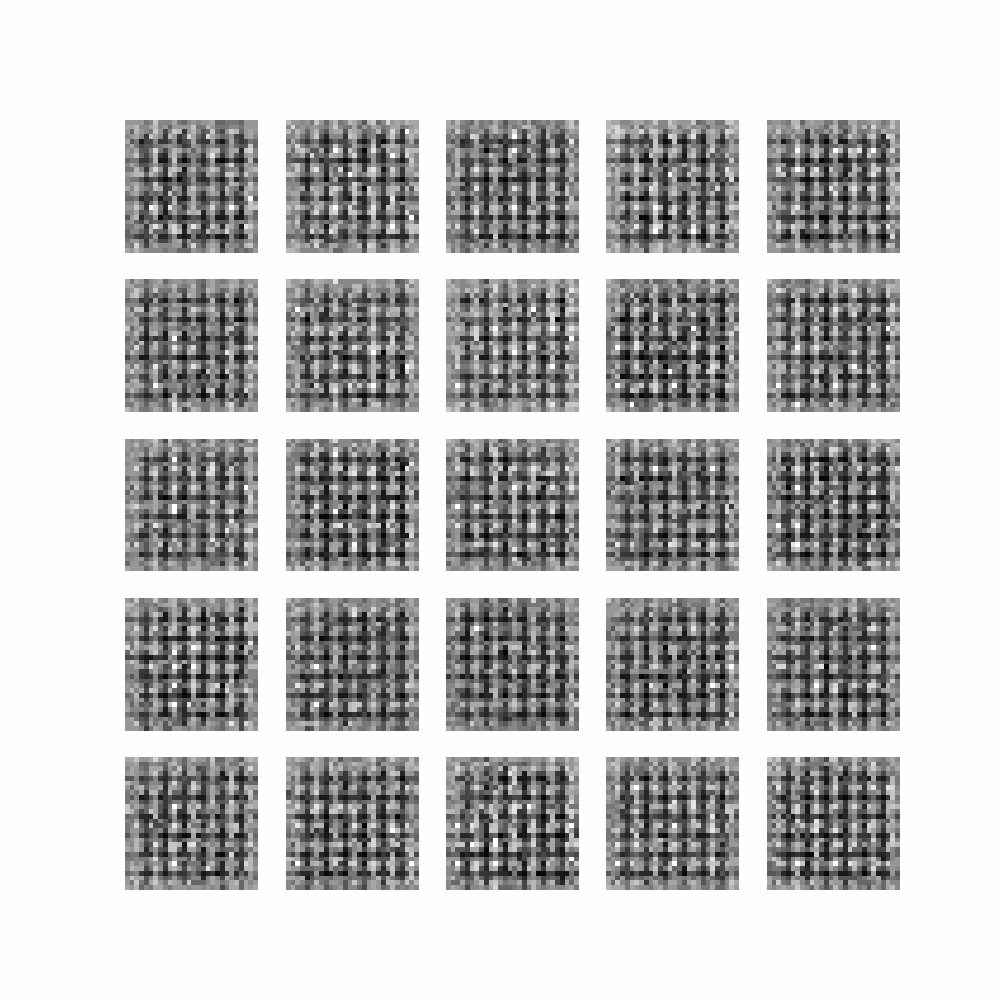

In [ ]:
import imageio
import os
from IPython.display import Image, display

# Define the directory where images are saved
save_dir = '/content/generated_images'

# Create a GIF file
gif_filename = 'generated_images.gif'
with imageio.get_writer(os.path.join(save_dir, gif_filename), mode='I') as writer:
    # Get all the filenames of images saved after each epoch
    filenames = sorted([img for img in os.listdir(save_dir) if img.endswith(".png")])

    for filename in filenames:
        image_path = os.path.join(save_dir, filename)
        image = imageio.imread(image_path)
        writer.append_data(image)

print(f"GIF saved in: {os.path.join(save_dir, gif_filename)}")
# Path to the saved GIF
gif_path = os.path.join(save_dir, 'generated_images.gif')

# Display the GIF in the notebook
display(Image(filename=gif_path))

# New Section

In [ ]:
# After training and saving images, zip folder
shutil.make_archive(save_dir, 'zip', save_dir)

files.download(f"{save_dir}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>